[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sapiosciences/sapio-py-tutorials/blob/master/9_python_record_models.ipynb)

In [ ]:
from sapiopylib.rest.DataMgmtService import DataMgmtServer
from sapiopylib.rest.DataRecordManagerService import DataRecordManager
from sapiopylib.rest.User import SapioUser
from sapiopylib.rest.utils.recordmodel.PyRecordModel import PyRecordModel
from sapiopylib.rest.utils.recordmodel.RecordModelManager import RecordModelManager, RecordModelInstanceManager, \
    RecordModelRelationshipManager

user = SapioUser(url="https://linux-vm:8443/webservice/api", verify_ssl_cert=False,
                 guid="3c232543-f407-4828-aae5-b33d4cd31fa7",
                 username="yqiao_api", password="Password1!")
dataRecordManager: DataRecordManager = DataMgmtServer.get_data_record_manager(user)

# Record Model Basics
Record model has been added to Sapio Commons library for a few years. This library module supported our Sapio plugin development, so that developers no longer need to pay as much attention to batching requests and can maintain a local state in which they can manipulate the data more easily.

The Python Record Model module is implemented to share the same design goals that we had in Java version of record models. It is capable of doing the following:


*   Create new records.
*   Manipulate existing records.
*   Create and remove parent-child links.
*   Maintains a record cache for all records and all links locally in Python client.
*   Extensible support for custom event handlers to fire at record creation/modification/link modification/store or rollback.

Let's get started! First, we will try to instantiate Python Record Models.

In [ ]:
rec_man: RecordModelManager = RecordModelManager(user)
inst_man: RecordModelInstanceManager = rec_man.instance_manager
relationship_man: RecordModelRelationshipManager = rec_man.relationship_manager

It is important to discuss how this instance was constructed.

Python Record Model is a caching system, and therefore maintaining a cache for the user without deleting the cache is important for data integrity and performance.

When this call is executed:
```
rec_man: RecordModelManager = RecordModelManager(user)
```
The module will first test whether there is an existing record model manager already created for this User instance. If an existing instance has been constructed before for this User instance, this module will not build a new Record Model Manager, but instead retrieve the existing one that is tied with this User instance.
In other words, the record model cache is singleton per user context.

Let's test what this actually means...

In [ ]:
sample_record = inst_man.add_new_record('Sample')
sample_record.set_field_value('OtherSampleId', 'PyRecordModel Test')
sample_record.set_field_value('ExemplarSampleType', 'DNA')
print(rec_man)
print(sample_record)

rec_man: RecordModelManager = RecordModelManager(user)
inst_man: RecordModelInstanceManager = rec_man.instance_manager
sample_record = inst_man.get_known_record_with_record_id(sample_record.record_id)
print(rec_man)
print(sample_record)

As you can see, it does not matter that I created a sample record, then reconstructed the record model manager. The actual cache as well as the record model manager reference are exactly the same.

Furthermore, you may also notice, the created sample record is not written yet to Sapio. If you try to search for this new sample, it does not exist. This is intentional, as we require user to explicitly call a "store and commit" method from record model manager before the data is transferred to Sapio for performance reasons.

Before running this example, create a location called "Default Location", make a child department with any other name than "Mice Research".
Let's complete this entire example for the first round. In this example, I will be searching for a location named "Default Location". I will rename this location to "My Location.
At the same time, I will create a new Department record, named "Mice Research", I will insert this sample, plus another sample, under the "Mice Research".

In [ ]:
# We first query the location with name 'Default Location', we assume this exists and no error handling here.
default_location_record = dataRecordManager.query_data_records('VeloxLocation',
                                                               'LocationName', ['Default Location']).result_list[0]

# We wrap this data record into a record model. In this case, we will use "add existing record" case which converts a DataRecord object into a PyRecordModel with a reference to the backing data record.
default_location: PyRecordModel = inst_man.add_existing_record(default_location_record)
# We change the value for default_location. Notice how the backing data record's field value has not yet changed.
default_location.set_field_value('LocationName', 'My Location')
print("Backing location record's location: " + default_location.get_data_record().get_field_value('LocationName'))
print("Record model's location name: " + default_location.get_field_value('LocationName'))

# Create a new department record model, directly without using a DataRecord backing it like we did before for sample.
mice_research_dept: PyRecordModel = inst_man.add_new_record('VeloxDepartment')
mice_research_dept.set_field_value('DepartmentName', 'Mice Research')
# Add this new department as a child record to location (in our record model cache)
default_location.add_child(mice_research_dept)

mice_research_dept.add_child(sample_record)
sample_record2 = inst_man.add_new_record('Sample')
sample_record2.set_field_value('OtherSampleId', 'PyRecordModel Test')
sample_record2.set_field_value('ExemplarSampleType', 'Urine')
mice_research_dept.add_child(sample_record2)

About obtaining relationship info: You can only obtain relationships either if you have already loaded relationship previously using the relationship manager, or if the record is new (or deleted)

Attempting to load an existing record's relationship without first calling the load request will throw an exception. However, you can do so for new records you have created.

The relationship of parent-child is reflective, so you can query both ways, for both new and existing relationships.

When you added relationship on top of relationships already exists, you will obtain the cached view of relationship with all changes reflected in the final list.

In [ ]:
from typing import List
from sapiopylib.rest.utils.recordmodel.PyRecordModel import SapioRecordModelException

try:
    default_location.get_children_of_type('VeloxDepartment')
except SapioRecordModelException as e:
    print(str(e))

relationship_man.load_children([default_location], 'VeloxDepartment')
print("Number of departments under Default Location: " + str(len(default_location.get_children_of_type('VeloxDepartment'))))

samples_under_dept: List[PyRecordModel] = mice_research_dept.get_children_of_type('Sample')
print("Number of samples under new Department: " +
      str(len(samples_under_dept)))

departments_above_sample: List[PyRecordModel] = sample_record.get_parents_of_type('VeloxDepartment')
print("Number of departments above Sample: " +
      str(len(departments_above_sample)))

Record Model with Record ID 90: Child type VeloxDepartment was not loaded.
Number of departments under Default Location: 2
Number of samples under new Department: 2
Number of departments above Sample: 1


Finally, we can make the changes permanent after we want to store these changes.

In [ ]:
rec_man.store_and_commit()

# Record Model with Wrappers

Record model wrappers decorates the root record models with syntax sugar. Getters and setters with appropriate field names and data type names are provided on to these wrapper classes, so programmers and readers of the code will find the utility is much easier to learn and use. Documentation-As-Code.

Record model wrappers can be generated in your platform.
Inside the Sapio Web Client, click App Setup under your profile icon, then select Configuration Manager => Webservice API Key from the left menu.

Click the button "Generate Python Record Model Wrappers for System Data Types" button.

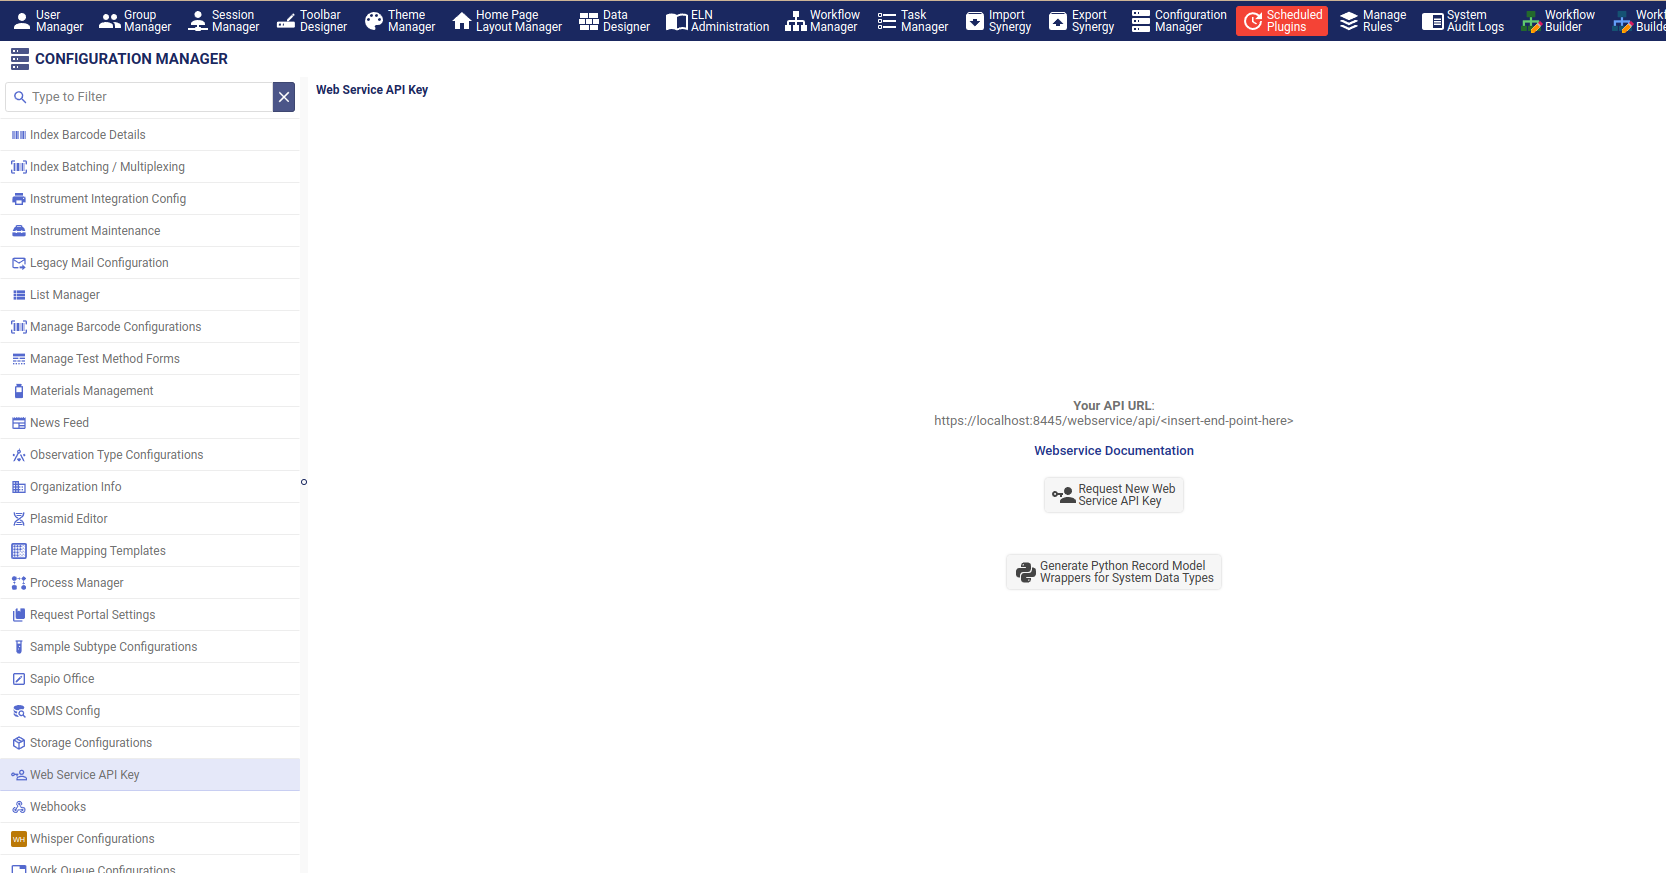

The platform will find all data types in the system and generate Python record model classes for each data type. Then the generates python code will be downloaded to you via the file browser. The file name will always be called "data_type_models.py", but you can rename this file after you receive it, if you wish. Note that the file name will become the module name when the file is loaded into a python script.

Here's an example of how we can use the wrappers:

In [ ]:
from sapiopylib.rest.DataMgmtService import DataMgmtServer
from sapiopylib.rest.DataRecordManagerService import DataRecordManager
from sapiopylib.rest.User import SapioUser
from sapiopylib.rest.utils.recordmodel.RecordModelManager import RecordModelManager

from data_Type_models import SampleModel

# Creating New Wrapped Record Models
user = SapioUser(url="https://linux-vm:8443/webservice/api", verify_ssl_cert=False,
                 guid="3c232543-f407-4828-aae5-b33d4cd31fa7",
                 username="yqiao_api", password="Password1!")
dataRecordManager: DataRecordManager = DataMgmtServer.get_data_record_manager(user)

rec_man = RecordModelManager(user)
inst_man = rec_man.instance_manager
relationship_man = rec_man.relationship_manager

# Whenever we need to fill a WrapperType generic variable as hinted by IDE, we can use the type of any wrapped models
# PyCharm may not correctly provides the typing hints without an explicit declaration of return WrapperType as of the latest release.
# Therefore, it can be important to declare ": SampleModel" here for PyCharm.
parent_sample: SampleModel = inst_man.add_new_record_of_type(SampleModel)
child_sample: SampleModel = inst_man.add_new_record_of_type(SampleModel)
parent_sample.add_child(child_sample)
parent_sample.set_OtherSampleId_field("Wrapped Record Model Testing Parent")
child_sample.set_OtherSampleId_field("Wrapped Record Model Testing Child")

rec_man.store_and_commit()

user = SapioUser(url="https://linux-vm:8443/webservice/api", verify_ssl_cert=False,
                 guid="3c232543-f407-4828-aae5-b33d4cd31fa7",
                 username="yqiao_api", password="Password1!")
dataRecordManager: DataRecordManager = DataMgmtServer.get_data_record_manager(user)

# Reading existing record models
rec_man = RecordModelManager(user)
inst_man = rec_man.instance_manager
relationship_man = rec_man.relationship_manager

parent_sample = inst_man.add_existing_record_of_type(parent_sample.get_data_record(), SampleModel)
relationship_man.load_children_of_type([parent_sample], SampleModel)
children_samples = parent_sample.get_children_of_type(SampleModel)
print([str(x) for x in children_samples])


# Record Model Properties
To provide consistency programming interface between wrapped record model and unwrapped record model, as well as being consistent with our Java Record Model API, we have implemented record model properties to both WrappedRecordModel and PyRecordModel classes. Some of the properties may require the proper load() method to be called before use.

There are following types of record model properties:


1.   Getter properties: obtain current info of a property of record model.
2.   Adder properties: assuming the property itself is of iterable type, add a new items into the iterable of the record model's specified property.
3.   Remover properties: assuming the property itself is of iterable type, remove items from the specified record model's property.
4.   Setter property: set the record model's specified property with a new value, overwriting any existing values if exists.

And so just like our sibling API in Java, here's an example of what you could do with our Record Model properties:

In [ ]:
from sapiopylib.rest.utils.recordmodel.properties import *

parent_sample: PyRecordModel = inst_man.add_new_record("Sample")
children_samples = parent_sample.add(Children.create_by_name("Sample", 5))
children_samples_test = parent_sample.get(Children.of_type_name("Sample"))

parent_sample.remove(Children.refs(children_samples))

parent_sample.add(Children.refs(children_samples))

You may also use their wrapped record model forms:

In [ ]:
parent_sample: SampleModel = inst_man.add_new_record_of_type(SampleModel)
child_sample: SampleModel = parent_sample.add(Child.create(SampleModel))
child_sample_test: SampleModel = parent_sample.get(Child.of_type(SampleModel))